In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose,STL
from statsmodels.tsa.holtwinters import SimpleExpSmoothing,Holt,ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.ar_model import AutoReg as AR,ARResults
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

In [3]:
df = pd.read_excel("CO2 dataset.xlsx")

In [4]:
df.index = pd.to_datetime(df['Year'], format='%Y')
df.drop('Year',axis=1, inplace=True)
df.head()

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 215 entries, 1800-01-01 to 2014-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO2     215 non-null    float64
dtypes: float64(1)
memory usage: 3.4 KB


In [6]:
df.isnull().sum()

CO2    0
dtype: int64

In [7]:
df.describe()

,CO2
count,215.000000
mean,6.741970
std,6.522437
min,0.001750
25%,0.041050
50%,6.390000
75%,11.500000
max,18.200000


In [8]:
df.head()

,CO2
Year,
1800-01-01,0.00568
1801-01-01,0.00561
1802-01-01,0.00555
1803-01-01,0.00548
1804-01-01,0.00542


In [9]:
df.tail()

,CO2
Year,
2010-01-01,15.6
2011-01-01,15.6
2012-01-01,14.8
2013-01-01,14.7
2014-01-01,15.1


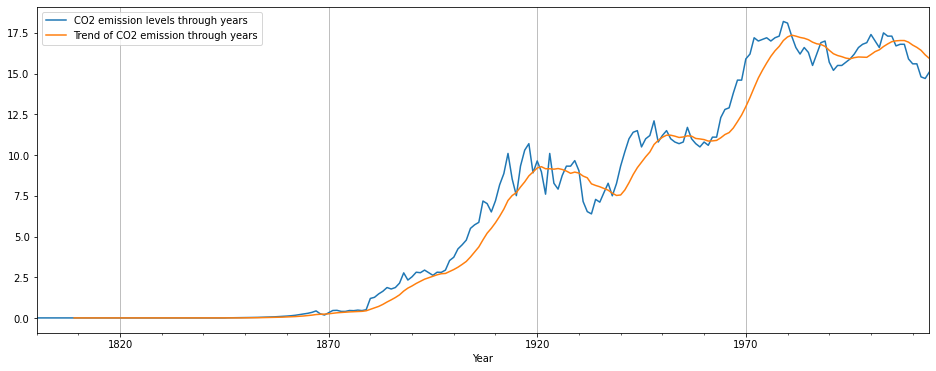

In [10]:
df['CO2'].plot(figsize=(16,6),legend=True,label='CO2 emission levels through years').autoscale(axis='x',tight=True);
df.rolling(window=10).mean()['CO2'].plot(legend=True,label='Trend of CO2 emission through years');
plt.grid(axis='x')

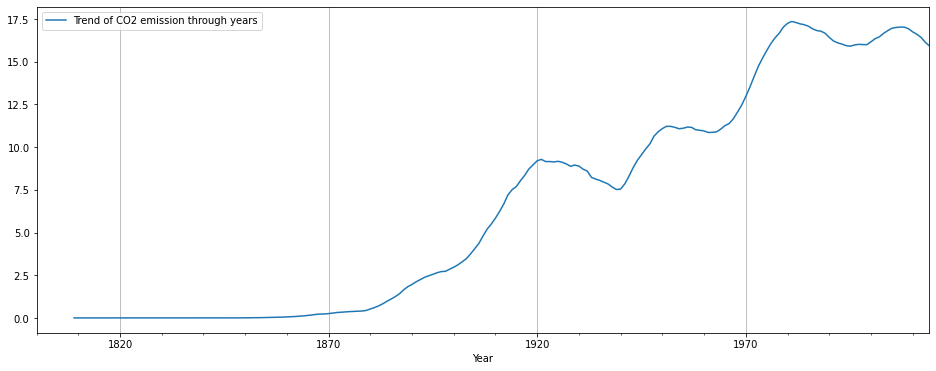

In [11]:
df.rolling(window=10).mean()['CO2'].plot(figsize=(16,6),legend=True,label='Trend of CO2 emission through years');
plt.grid(axis='x')

##### The first peak in CO2 emissions we see in timeframe of 1900 -1925 is due to World War 1 which occured during 1914 – 1918
##### The first peak in CO2 emissions we see in timeframe of 1930 -1950 is due to World War 2 which occured during 1939 – 1945
##### The first peak in CO2 emissions we see in timeframe of 1960 -1990 is due to various advancements during war that found commerial usage, rise in use of electronic appliances and economic boom in west.

<AxesSubplot:title={'center':'Total CO2 emitted over years'}, xlabel='Year'>

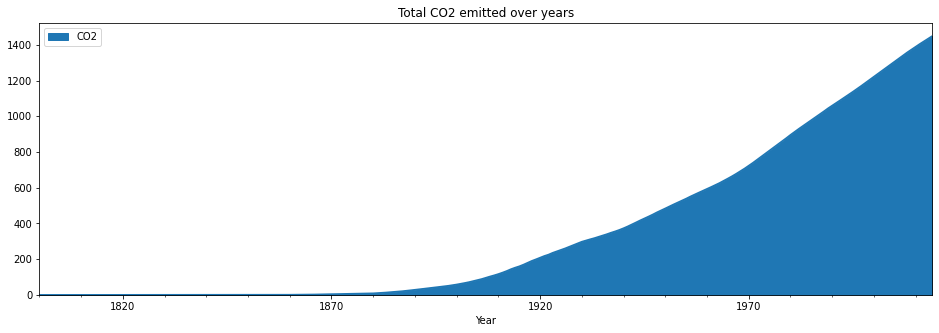

In [12]:
df.cumsum().plot(figsize=(16,5),kind = 'area',title='Total CO2 emitted over years')

In [13]:
# help(seasonal_decompose)

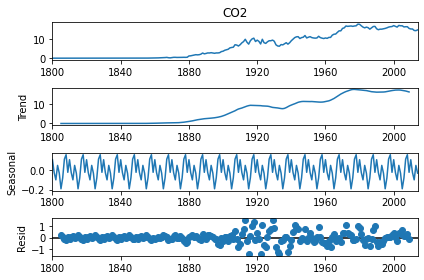

In [14]:
seasonal_dcp = seasonal_decompose(df['CO2'],period=10)
seasonal_dcp.plot();

In [15]:
# help(STL)

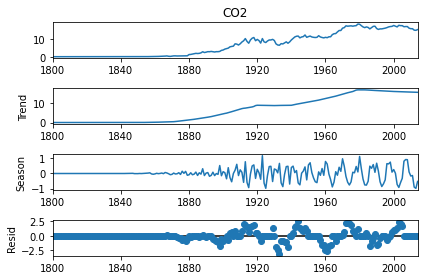

In [16]:
res = STL(df["CO2"],period =10, robust=True).fit()
res.plot()
plt.show()

In [17]:
from statsmodels.tsa.filters.hp_filter import hpfilter
gdp_cycle, gdp_trend = hpfilter(df['CO2'], lamb=6.25)

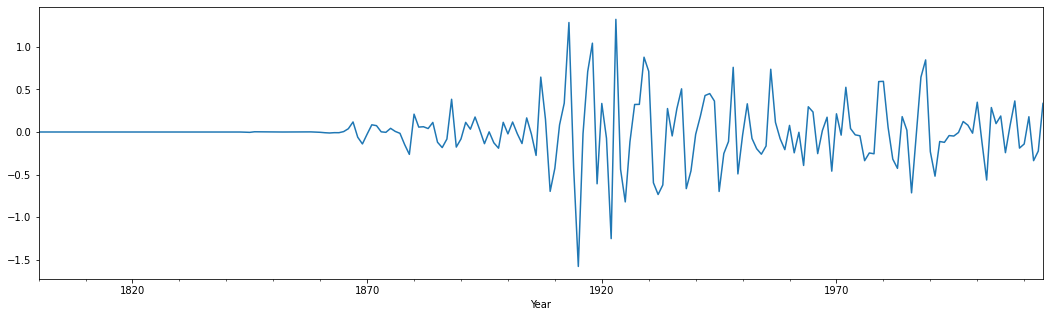

In [18]:
gdp_cycle.plot(figsize=(18,5)).autoscale(axis='x',tight=True);

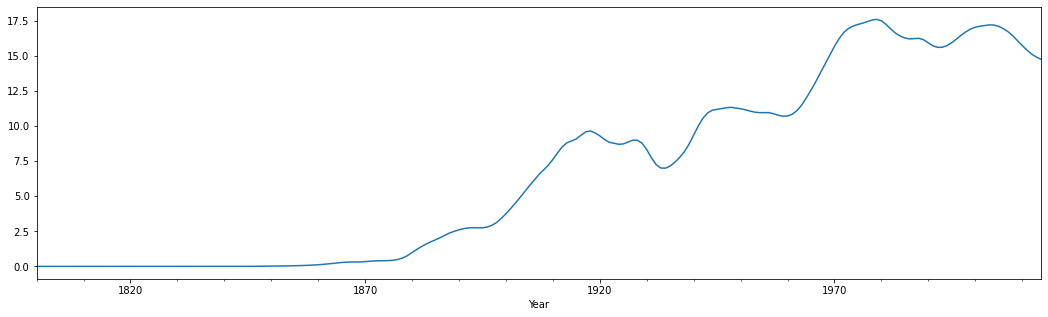

In [19]:
gdp_trend.plot(figsize=(18,5)).autoscale(axis='x',tight=True)

In [20]:
def adf_test(series,title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')     # .dropna() handles differenced data    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    print(out.to_string())                               # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:                                # 5% significance
        print("Data has no unit root and is stationary")
    else:
        print("Data has a unit root and is non-stationary")

In [21]:
adf_test(df['CO2'],'og')

Augmented Dickey-Fuller Test: og
ADF test statistic     -0.378463
p-value                 0.913633
# lags used             0.000000
# observations        214.000000
Data has a unit root and is non-stationary


#### Applying differencing to make the time-series stationary

In [22]:
df['sft_1'] = df['CO2'] - df['CO2'].shift(1)
df.dropna(inplace=True)

<AxesSubplot:xlabel='Year'>

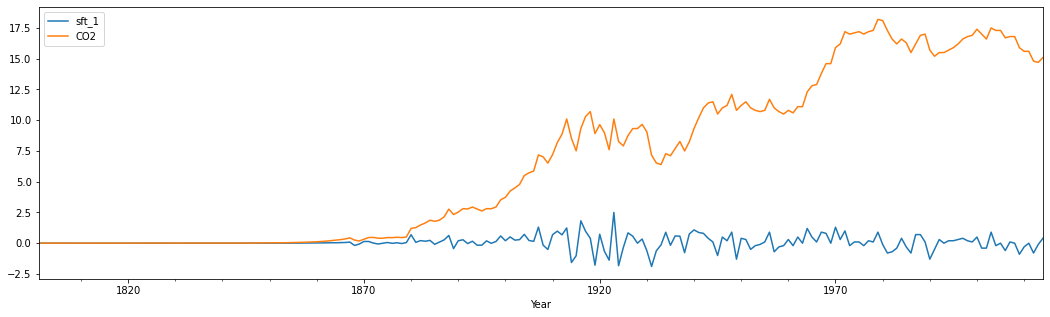

In [22]:
df[['sft_1','CO2']].plot(figsize=(18,5))

In [23]:
adf_test(df['sft_1'],'sft_1')

Augmented Dickey-Fuller Test: sft_1
ADF test statistic     -3.780005
p-value                 0.003119
# lags used            15.000000
# observations        198.000000
Data has no unit root and is stationary


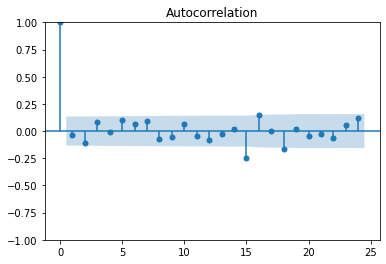

In [24]:
plot_acf(df['sft_1']);

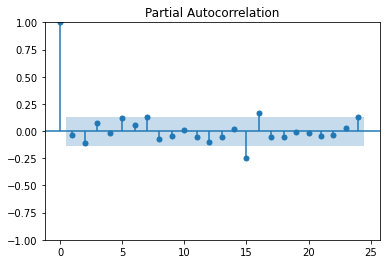

In [25]:
plot_pacf(df['sft_1'],method='ywm');

#### Non Stationary data

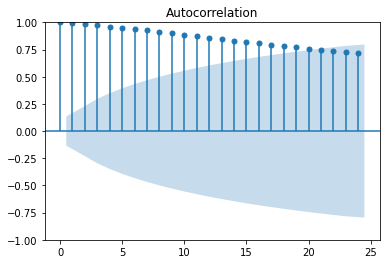

In [26]:
plot_acf(df['CO2']);

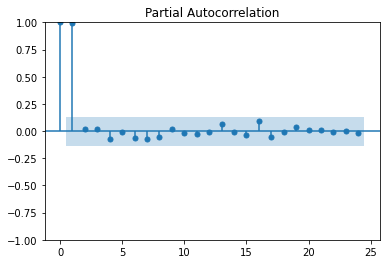

In [27]:
plot_pacf(df['CO2'],method='ywm');

#### Model building

In [28]:
def error_and_plot(test,predictions,title=''):
    print(f'Model: {title}')
    rmse=sqrt(mean_squared_error(test,predictions))
    print(f'Error = {rmse}')
    fig = plt.figure(figsize=(12,4))
    plt.plot(test, label='Original')
    plt.plot(predictions, color='red', label='Prediction')
    plt.legend();

In [29]:
auto_arima(df['CO2'],error_action='ignore',seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  214
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -174.430
Date:                Thu, 18 Aug 2022   AIC                            352.861
Time:                        16:01:46   BIC                            359.583
Sample:                             0   HQIC                           355.577
                                - 214                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0709      0.038      1.881      0.060      -0.003       0.145
sigma2         0.3012      0.017     17.301      0.000       0.267       0.335
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):               118.24
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):              56.87   Skew:                            -0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
X = df['CO2'].head(204)
y = df['CO2'].tail(10)

#### SARIMAX(0, 1, 0)

In [31]:
model = SARIMAX(X,order=(0, 1, 0))
results = model.fit()
results.summary()

C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                  204
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -169.511
Date:                Thu, 18 Aug 2022   AIC                            341.021
Time:                        16:01:46   BIC                            344.334
Sample:                    01-01-1801   HQIC                           342.362
                         - 01-01-2004                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.3110      0.019     16.706      0.000       0.275       0.348
===================================================================================
Ljung-Box (L1) (Q):                   0.50   Jarque-Bera (JB):               121.14
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):             426.26   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
start = len(X)
end = len(X) + len(y) - 1

In [33]:
predictions_sarima_1 = results.predict(start,end)

Model: SARIMAX(0, 1, 0)
Error = 1.62634559672906


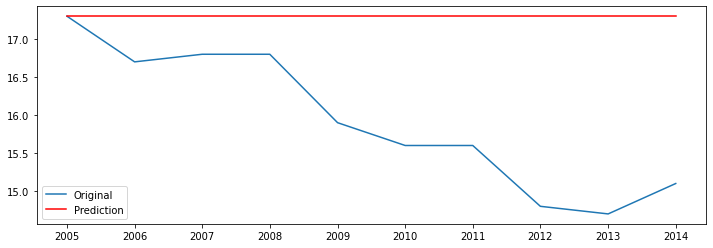

In [34]:
error_and_plot(y,predictions_sarima_1,'SARIMAX(0, 1, 0)')

#### ARIMA(0,1,0)

In [35]:
model_arima = ARIMA(X,order=(0,1,0))
results_1 = model_arima.fit()
results_1.summary()

C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                  204
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -169.511
Date:                Thu, 18 Aug 2022   AIC                            341.021
Time:                        16:01:46   BIC                            344.334
Sample:                    01-01-1801   HQIC                           342.362
                         - 01-01-2004                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.3110      0.019     16.706      0.000       0.275       0.348
===================================================================================
Ljung-Box (L1) (Q):                   0.50   Jarque-Bera (JB):               121.14
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):             426.26   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
start=len(X)
end=len(X)+len(y)-1
predictions = results_1.predict(start=start, end=end, dynamic=False, typ='levels')

Model: ARIMA(0, 1, 0)
Error = 1.62634559672906


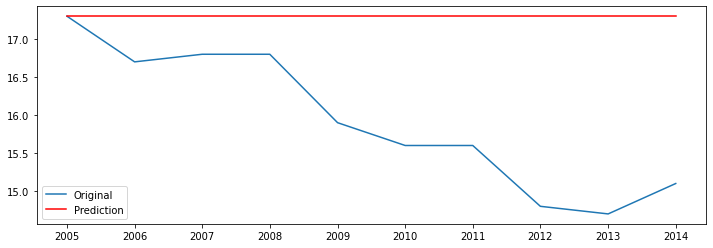

In [37]:
error_and_plot(y,predictions,'ARIMA(0, 1, 0)')

#### ARIMA(1,1,0)

In [38]:
model_arima_1 = ARIMA(X,order=(1,1,0))
results_2 = model_arima_1.fit()
results_2.summary()

C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                  204
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -169.450
Date:                Thu, 18 Aug 2022   AIC                            342.901
Time:                        16:01:46   BIC                            349.527
Sample:                    01-01-1801   HQIC                           345.582
                         - 01-01-2004                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0244      0.043     -0.561      0.575      -0.110       0.061
sigma2         0.3109      0.021     14.928      0.000       0.270       0.352
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):               110.85
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):             424.58   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
start=len(X)
end=len(X)+len(y)-1
predictions = results_2.predict(start=start, end=end, dynamic=False, typ='levels')

In [40]:
predictions

2005-01-01    17.304878
2006-01-01    17.304759
2007-01-01    17.304762
2008-01-01    17.304761
2009-01-01    17.304761
2010-01-01    17.304761
2011-01-01    17.304761
2012-01-01    17.304761
2013-01-01    17.304761
2014-01-01    17.304761
Freq: AS-JAN, Name: predicted_mean, dtype: float64

Model: ARIMA(1, 1, 0)
Error = 1.630358502446109


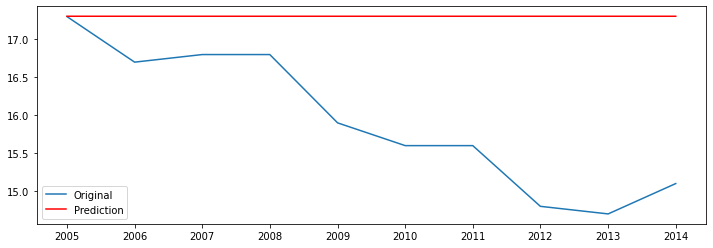

In [41]:
error_and_plot(y,predictions,'ARIMA(1, 1, 0)')

#### ARIMA (15,1,0)

In [42]:
model_arima_2 = ARIMA(X,order=(15,1,0))
results_3 = model_arima_2.fit()
results_3.summary()

C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    CO2   No. Observations:                  204
Model:                ARIMA(15, 1, 0)   Log Likelihood                -155.458
Date:                Thu, 18 Aug 2022   AIC                            342.916
Time:                        16:01:46   BIC                            395.927
Sample:                    01-01-1801   HQIC                           364.362
                         - 01-01-2004                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0262      0.053     -0.498      0.619      -0.129       0.077
ar.L2         -0.1105      0.050     -2.209      0.027      -0.209      -0.012
ar.L3          0.0747      0.052      1.429      0.153      -0.028       0.177
ar.L4         -0.0291      0.053     -0.552      0.581      -0.133       0.074
ar.L5          0.1744      0.054      3.246      0.001       0.069       0.280
ar.L6          0.1042      0.061      1.715      0.086      -0.015       0.223
ar.L7          0.1341      0.057      2.347      0.019       0.022       0.246
ar.L8         -0.0181      0.051     -0.352      0.725      -0.119       0.083
ar.L9          0.0138      0.049      0.279      0.780      -0.083       0.111
ar.L10         0.0707      0.057      1.231      0.218      -0.042       0.183
ar.L11        -0.0537      0.054     -0.989      0.323      -0.160       0.053
ar.L12        -0.0555      0.071     -0.783      0.434      -0.194       0.083
ar.L13        -0.0509      0.066     -0.777      0.437      -0.179       0.078
ar.L14         0.0340      0.056      0.605      0.545      -0.076       0.144
ar.L15        -0.2332      0.056     -4.170      0.000      -0.343      -0.124
sigma2         0.2690      0.024     11.424      0.000       0.223       0.315
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                34.12
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):             400.45   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
start=len(X)
end=len(X)+len(y)-1
predictions = results_3.predict(start=start, end=end, dynamic=False, typ='levels')

Model: ARIMA(15, 1, 0)
Error = 1.8745056259639792


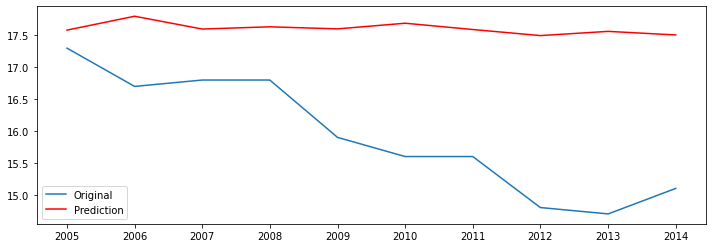

In [44]:
error_and_plot(y,predictions,'ARIMA(15, 1, 0)')

### ARMA model with Stationary data

In [45]:
X = df['sft_1'].iloc[:200]
y = df['sft_1'].iloc[200:]

In [46]:
model_st = ARIMA(X,order=(15,0,15))
results_st = model_st.fit()
results_st.summary()

C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sft_1   No. Observations:                  200
Model:               ARIMA(15, 0, 15)   Log Likelihood                -131.869
Date:                Thu, 18 Aug 2022   AIC                            327.738
Time:                        16:01:49   BIC                            433.284
Sample:                    01-01-1801   HQIC                           370.451
                         - 01-01-2000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0879      0.048      1.838      0.066      -0.006       0.182
ar.L1         -0.0712      0.555     -0.128      0.898      -1.159       1.017
ar.L2         -0.0263      0.282     -0.093      0.926      -0.579       0.527
ar.L3          0.2279      0.242      0.942      0.346      -0.246       0.702
ar.L4         -0.2800      0.447     -0.626      0.531      -1.156       0.596
ar.L5         -0.0843      0.364     -0.231      0.817      -0.798       0.629
ar.L6          0.2030      0.198      1.023      0.306      -0.186       0.592
ar.L7          0.3082      0.236      1.305      0.192      -0.155       0.771
ar.L8          0.0064      0.312      0.020      0.984      -0.605       0.618
ar.L9         -0.1370      0.207     -0.663      0.507      -0.542       0.268
ar.L10        -0.2742      0.253     -1.085      0.278      -0.770       0.221
ar.L11         0.2059      0.265      0.776      0.438      -0.314       0.726
ar.L12        -0.1743      0.228     -0.763      0.445      -0.622       0.273
ar.L13        -0.2135      0.185     -1.154      0.249      -0.576       0.149
ar.L14        -0.2634      0.165     -1.595      0.111      -0.587       0.060
ar.L15        -0.3170      0.268     -1.182      0.237      -0.843       0.209
ma.L1          0.0874      0.549      0.159      0.874      -0.989       1.164
ma.L2         -0.0486      0.441     -0.110      0.912      -0.913       0.815
ma.L3         -0.2845      0.299     -0.952      0.341      -0.870       0.301
ma.L4          0.2197      0.449      0.490      0.624      -0.659       1.099
ma.L5          0.3225      0.344      0.937      0.349      -0.352       0.997
ma.L6         -0.0749      0.465     -0.161      0.872      -0.987       0.837
ma.L7         -0.2421      0.324     -0.747      0.455      -0.877       0.393
ma.L8         -0.1731      0.462     -0.374      0.708      -1.079       0.733
ma.L9          0.1766      0.301      0.586      0.558      -0.414       0.767
ma.L10         0.5755      0.432      1.332      0.183      -0.271       1.422
ma.L11        -0.3951      0.468     -0.845      0.398      -1.312       0.522
ma.L12         0.0010      0.337      0.003      0.998      -0.659       0.661
ma.L13         0.2042      0.224      0.911      0.362      -0.235       0.643
ma.L14         0.4205      0.286      1.471      0.141      -0.140       0.981
ma.L15         0.1549      0.432      0.359      0.720      -0.691       1.001
sigma2         0.2052      0.074      2.774      0.006       0.060       0.350
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                25.79
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              35.63   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.76
========================================================

In [47]:
start=len(X)
end=len(X)+len(y)-1
predictions = results_st.predict(start=start, end=end, dynamic=False, typ='levels')

Model: ARMA(15,0,15)
Error = 0.6711330376170662


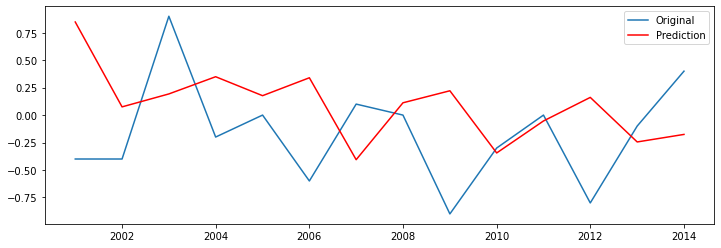

In [48]:
error_and_plot(y,predictions,'ARMA(15,0,15)')

##### AR (15) 

In [49]:
model_st1 = ARIMA(X,order=(15,0,0))
results_st1 = model_st1.fit()
results_st1.summary()

C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sft_1   No. Observations:                  200
Model:                ARIMA(15, 0, 0)   Log Likelihood                -148.127
Date:                Thu, 18 Aug 2022   AIC                            330.254
Time:                        16:01:50   BIC                            386.326
Sample:                    01-01-1801   HQIC                           352.945
                         - 01-01-2000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0906      0.034      2.695      0.007       0.025       0.156
ar.L1         -0.0394      0.051     -0.770      0.441      -0.140       0.061
ar.L2         -0.1294      0.049     -2.661      0.008      -0.225      -0.034
ar.L3          0.0369      0.054      0.678      0.498      -0.070       0.143
ar.L4         -0.0470      0.056     -0.847      0.397      -0.156       0.062
ar.L5          0.1592      0.055      2.901      0.004       0.052       0.267
ar.L6          0.0849      0.065      1.302      0.193      -0.043       0.213
ar.L7          0.1127      0.062      1.804      0.071      -0.010       0.235
ar.L8         -0.0321      0.051     -0.631      0.528      -0.132       0.068
ar.L9         -0.0048      0.049     -0.098      0.922      -0.100       0.090
ar.L10         0.0457      0.057      0.797      0.426      -0.067       0.158
ar.L11        -0.1054      0.055     -1.926      0.054      -0.213       0.002
ar.L12        -0.0840      0.076     -1.106      0.269      -0.233       0.065
ar.L13        -0.0597      0.077     -0.775      0.438      -0.211       0.091
ar.L14         0.0150      0.057      0.262      0.794      -0.097       0.127
ar.L15        -0.2731      0.060     -4.583      0.000      -0.390      -0.156
sigma2         0.2553      0.022     11.855      0.000       0.213       0.298
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):                36.60
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):              26.83   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
start=len(X)
end=len(X)+len(y)-1
predictions = results_st1.predict(start=start, end=end, dynamic=False, typ='levels')

Model: AR(15)
Error = 0.576826587391671


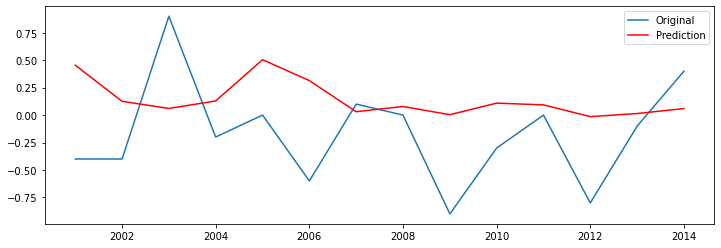

In [51]:
error_and_plot(y,predictions,'AR(15)')

#### MA (15)



In [52]:
model_st2 = ARIMA(X,order=(0,0,15))
results_st2 = model_st2.fit()
results_st2.summary()

C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
C:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sft_1   No. Observations:                  200
Model:                ARIMA(0, 0, 15)   Log Likelihood                -145.028
Date:                Thu, 18 Aug 2022   AIC                            324.056
Time:                        16:01:51   BIC                            380.127
Sample:                    01-01-1801   HQIC                           346.747
                         - 01-01-2000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0902      0.042      2.172      0.030       0.009       0.172
ma.L1          0.0348      0.059      0.591      0.555      -0.081       0.150
ma.L2         -0.0717      0.062     -1.150      0.250      -0.194       0.050
ma.L3         -0.0358      0.047     -0.769      0.442      -0.127       0.055
ma.L4         -0.0943      0.056     -1.678      0.093      -0.204       0.016
ma.L5          0.2136      0.065      3.301      0.001       0.087       0.340
ma.L6          0.1150      0.064      1.811      0.070      -0.009       0.239
ma.L7          0.0397      0.059      0.675      0.499      -0.076       0.155
ma.L8         -0.1151      0.060     -1.924      0.054      -0.232       0.002
ma.L9         -0.0347      0.059     -0.588      0.556      -0.150       0.081
ma.L10         0.1209      0.059      2.052      0.040       0.005       0.236
ma.L11        -0.2065      0.062     -3.335      0.001      -0.328      -0.085
ma.L12        -0.0409      0.056     -0.736      0.462      -0.150       0.068
ma.L13         0.1608      0.057      2.818      0.005       0.049       0.273
ma.L14         0.0479      0.060      0.804      0.421      -0.069       0.165
ma.L15        -0.2465      0.065     -3.821      0.000      -0.373      -0.120
sigma2         0.2438      0.021     11.890      0.000       0.204       0.284
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                36.52
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):              33.72   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
start=len(X)
end=len(X)+len(y)-1
predictions = results_st2.predict(start=start, end=end, dynamic=False, typ='levels')

Model: MA(15)
Error = 0.6398286982935557


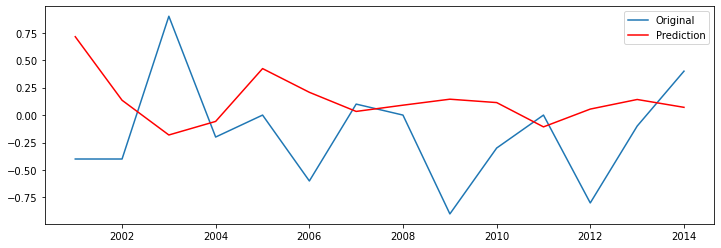

In [54]:
error_and_plot(y,predictions,'MA(15)')

In [55]:
df

,CO2,sft_1
Year,,
1801-01-01,0.00561,-0.00007
1802-01-01,0.00555,-0.00006
1803-01-01,0.00548,-0.00007
1804-01-01,0.00542,-0.00006
1805-01-01,0.00536,-0.00006
...,...,...
2010-01-01,15.60000,-0.30000
2011-01-01,15.60000,0.00000
2012-01-01,14.80000,-0.80000


### ML Regression Models

#### Linear regression

Model: linear regression
Error = 9.819469786058905


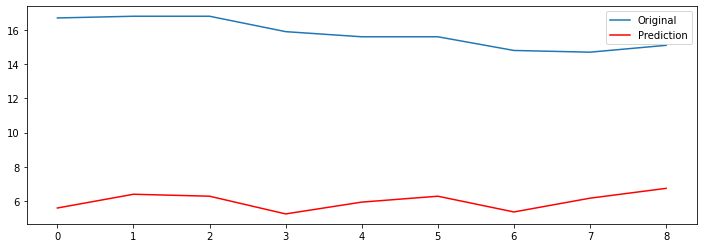

In [56]:
lin_model = LinearRegression()

X_train = df['sft_1'].iloc[:205]
y_train = df['CO2'].iloc[:205]
X_test = df['sft_1'].iloc[205:]
y_test = df['CO2'].iloc[205:]

X_train,X_test,y_train,y_test=np.array(X_train),np.array(X_test),np.array(y_train),np.array(y_test)
X_train,X_test,y_train,y_test=X_train.reshape(-1,1),X_test.reshape(-1,1),y_train.reshape(-1,1),y_test.reshape(-1,1)

lin_model.fit(X_train,y_train)
prediction = lin_model.predict(X_test)

error_and_plot(y_test,prediction,'linear regression')

#### RandomForest Regressor

Model: random forest regression
Error = 3.6014164763017074


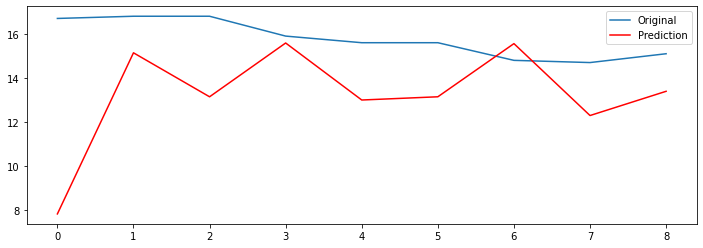

In [57]:
rmf_model = RandomForestRegressor(n_estimators=100,max_features=1, random_state=1)

y_train = y_train.ravel()

rmf_model.fit(X_train,y_train)
preds = rmf_model.predict(X_test)

error_and_plot(y_test,preds,'random forest regression')

#### XGBRegressor model

In [58]:
reg = XGBRegressor(n_estimators=500, learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],eval_metric='mae')

[0]	validation_0-mae:6.13231	validation_1-mae:15.16740
[1]	validation_0-mae:6.07542	validation_1-mae:15.05803
[2]	validation_0-mae:6.01905	validation_1-mae:14.94963
[3]	validation_0-mae:5.96322	validation_1-mae:14.84221
[4]	validation_0-mae:5.90792	validation_1-mae:14.73576
[5]	validation_0-mae:5.85313	validation_1-mae:14.63026
[6]	validation_0-mae:5.79891	validation_1-mae:14.52572
[7]	validation_0-mae:5.74611	validation_1-mae:14.42211
[8]	validation_0-mae:5.69382	validation_1-mae:14.31944
[9]	validation_0-mae:5.64202	validation_1-mae:14.21769
[10]	validation_0-mae:5.59072	validation_1-mae:14.11686
[11]	validation_0-mae:5.53989	validation_1-mae:14.01693
[12]	validation_0-mae:5.48954	validation_1-mae:13.91790
[13]	validation_0-mae:5.43966	validation_1-mae:13.81976
[14]	validation_0-mae:5.39026	validation_1-mae:13.72251
[15]	validation_0-mae:5.34130	validation_1-mae:13.62612
[16]	validation_0-mae:5.29280	validation_1-mae:13.53061
[17]	validation_0-mae:5.24510	validation_1-mae:13.43770
[1

[148]	validation_0-mae:2.03521	validation_1-mae:6.19677
[149]	validation_0-mae:2.02536	validation_1-mae:6.16653
[150]	validation_0-mae:2.01573	validation_1-mae:6.13728
[151]	validation_0-mae:2.00640	validation_1-mae:6.10852
[152]	validation_0-mae:1.99700	validation_1-mae:6.07975


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[153]	validation_0-mae:1.98812	validation_1-mae:6.05133
[154]	validation_0-mae:1.97892	validation_1-mae:6.02349
[155]	validation_0-mae:1.96967	validation_1-mae:5.99461
[156]	validation_0-mae:1.96088	validation_1-mae:5.96597
[157]	validation_0-mae:1.95251	validation_1-mae:5.93831
[158]	validation_0-mae:1.94418	validation_1-mae:5.91011
[159]	validation_0-mae:1.93606	validation_1-mae:5.88291
[160]	validation_0-mae:1.92816	validation_1-mae:5.85594
[161]	validation_0-mae:1.92035	validation_1-mae:5.82884
[162]	validation_0-mae:1.91261	validation_1-mae:5.80196
[163]	validation_0-mae:1.90491	validation_1-mae:5.77563
[164]	validation_0-mae:1.89776	validation_1-mae:5.75030
[165]	validation_0-mae:1.89026	validation_1-mae:5.72405
[166]	validation_0-mae:1.88293	validation_1-mae:5.69833
[167]	validation_0-mae:1.87569	validation_1-mae:5.67248
[168]	validation_0-mae:1.86866	validation_1-mae:5.64659
[169]	validation_0-mae:1.86178	validation_1-mae:5.62147
[170]	validation_0-mae:1.85508	validation_1-mae:

[300]	validation_0-mae:1.44087	validation_1-mae:3.60118
[301]	validation_0-mae:1.43953	validation_1-mae:3.59276
[302]	validation_0-mae:1.43800	validation_1-mae:3.58533
[303]	validation_0-mae:1.43688	validation_1-mae:3.57584
[304]	validation_0-mae:1.43541	validation_1-mae:3.56545
[305]	validation_0-mae:1.43414	validation_1-mae:3.55756
[306]	validation_0-mae:1.43327	validation_1-mae:3.54893
[307]	validation_0-mae:1.43182	validation_1-mae:3.53914
[308]	validation_0-mae:1.43049	validation_1-mae:3.53118
[309]	validation_0-mae:1.42916	validation_1-mae:3.52000
[310]	validation_0-mae:1.42797	validation_1-mae:3.51243
[311]	validation_0-mae:1.42655	validation_1-mae:3.50290
[312]	validation_0-mae:1.42526	validation_1-mae:3.49518
[313]	validation_0-mae:1.42394	validation_1-mae:3.48752
[314]	validation_0-mae:1.42282	validation_1-mae:3.47715
[315]	validation_0-mae:1.42171	validation_1-mae:3.46521
[316]	validation_0-mae:1.42027	validation_1-mae:3.45861
[317]	validation_0-mae:1.41928	validation_1-mae:

[447]	validation_0-mae:1.32403	validation_1-mae:2.88516
[448]	validation_0-mae:1.32324	validation_1-mae:2.88075
[449]	validation_0-mae:1.32301	validation_1-mae:2.87987
[450]	validation_0-mae:1.32262	validation_1-mae:2.87685
[451]	validation_0-mae:1.32238	validation_1-mae:2.87564
[452]	validation_0-mae:1.32199	validation_1-mae:2.87264
[453]	validation_0-mae:1.32145	validation_1-mae:2.87006
[454]	validation_0-mae:1.32138	validation_1-mae:2.86921
[455]	validation_0-mae:1.32085	validation_1-mae:2.86665
[456]	validation_0-mae:1.32077	validation_1-mae:2.86582
[457]	validation_0-mae:1.32070	validation_1-mae:2.86499
[458]	validation_0-mae:1.32030	validation_1-mae:2.86206
[459]	validation_0-mae:1.31987	validation_1-mae:2.86111
[460]	validation_0-mae:1.31948	validation_1-mae:2.85820
[461]	validation_0-mae:1.31894	validation_1-mae:2.85571
[462]	validation_0-mae:1.31886	validation_1-mae:2.85493
[463]	validation_0-mae:1.31843	validation_1-mae:2.85401
[464]	validation_0-mae:1.31804	validation_1-mae:

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [59]:
predictions_xg = reg.predict(X_test)

Model: XGBoost
Error = 3.465489672047403


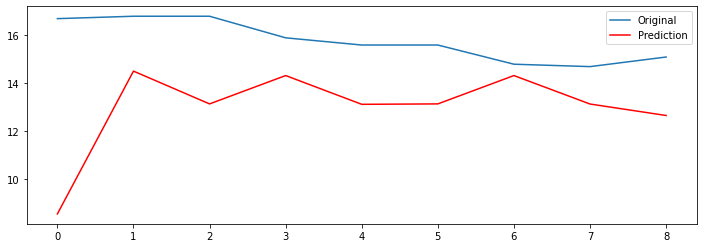

In [60]:
error_and_plot(y_test,predictions_xg,'XGBoost')

## Forecasting using LSTM

In [61]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM,Dense

### On Stationary data

In [62]:
train = df['sft_1'].iloc[:205] 
test = df['sft_1'].iloc[205:]

train = train.to_numpy()
test = test.to_numpy()

n_input = 5
n_features = 1 
generator = TimeseriesGenerator(train,train,length=n_input,batch_size=1)

model1 = Sequential()
model1.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model1.add(Dense(10, activation='relu'))
model1.add(Dense(1))
model1.compile(optimizer='adam', loss='mse')

model1.fit(generator,epochs=100)

Epoch 1/100
200/200 [==============================] - 1s 1ms/step - loss: 0.3155
Epoch 2/100
200/200 [==============================] - 0s 1ms/step - loss: 0.3105
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 0.3127
Epoch 4/100
200/200 [==============================] - 0s 1ms/step - loss: 0.3091
Epoch 5/100
200/200 [==============================] - 0s 1ms/step - loss: 0.3089
Epoch 6/100
200/200 [==============================] - 0s 2ms/step - loss: 0.3116
Epoch 7/100
200/200 [==============================] - 0s 1ms/step - loss: 0.3114
Epoch 8/100
200/200 [==============================] - 0s 1ms/step - loss: 0.3088
Epoch 9/100
200/200 [==============================] - 0s 1ms/step - loss: 0.3076
Epoch 10/100
200/200 [==============================] - 0s 2ms/step - loss: 0.3071
Epoch 11/100
200/200 [==============================] - 0s 1ms/step - loss: 0.3053
Epoch 12/100
200/200 [==============================] - 0s 1ms/step - loss: 0.3044
Epoch 13/100


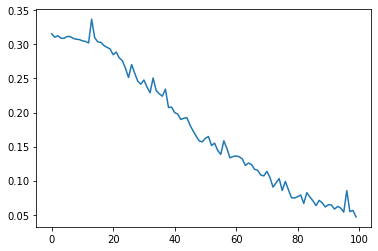

In [63]:
loss_1 = model1.history.history['loss']
plt.plot(range(len(loss_1)),loss_1)

In [64]:
test_predictions_1 = []

first_eval_batch = train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model1.predict(current_batch)[0]
    test_predictions_1.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

Model: LSTM RNN on stationary data
Error = 0.5063732681925973


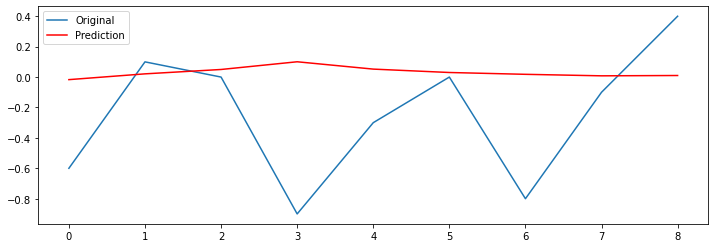

In [65]:
error_and_plot(test,test_predictions_1,'LSTM RNN on stationary data')

### Scaled data

In [67]:
from sklearn.preprocessing import MinMaxScaler

In [68]:
df = pd.read_excel("CO2 dataset.xlsx")
df.index = pd.to_datetime(df['Year'], format='%Y')
df.drop('Year',axis=1, inplace=True)

In [69]:
scaler = MinMaxScaler()

train = df.iloc[:200] 
test = df.iloc[200:]

scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

n_input = 4
n_features = 1 
generator = TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

model2 = Sequential()
model2.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model2.add(Dense(10, activation='relu'))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse')

model2.fit(generator,epochs=50)

Epoch 1/50
196/196 [==============================] - 1s 1ms/step - loss: 0.0302
Epoch 2/50
196/196 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 3/50
196/196 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 4/50
196/196 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 5/50
196/196 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 6/50
196/196 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 7/50
196/196 [==============================] - 0s 1ms/step - loss: 0.0025
Epoch 8/50
196/196 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 9/50
196/196 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 10/50
196/196 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 11/50
196/196 [==============================] - 0s 1ms/step - loss: 0.0018
Epoch 12/50
196/196 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 13/50
196/196 [====

In [70]:
test_predictions_2 = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model2.predict(current_batch)[0]
    test_predictions_2.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [71]:
true_predictions_2 = scaler.inverse_transform(test_predictions_2)

Model: LSTM with scaled data
Error = 4.203535088426849


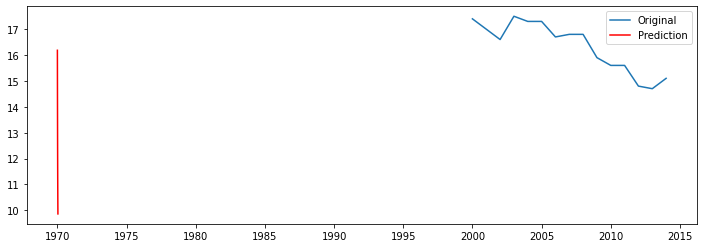

In [72]:
error_and_plot(test,true_predictions_2,'LSTM with scaled data')

In [73]:
true_predictions_2

array([[16.18464759],
       [15.43054772],
       [14.6914601 ],
       [14.00118074],
       [13.38380083],
       [12.83556079],
       [12.34816051],
       [11.91277919],
       [11.52216671],
       [11.17062513],
       [10.85348481],
       [10.56688966],
       [10.3076398 ],
       [10.07292694],
       [ 9.86028665]])

### Unscaled data

In [74]:
len(df)

215

In [75]:
train = df.iloc[:205] 
test = df.iloc[205:]

train = train.to_numpy()
test = test.to_numpy()

n_input = 5
n_features = 1 
generator = TimeseriesGenerator(train,train,length=n_input,batch_size=1)

model3 = Sequential()
model3.add(LSTM(150, activation='relu', input_shape=(n_input, n_features)))
model3.add(Dense(10, activation='relu'))
model3.add(Dense(1))
model3.compile(optimizer='adam', loss='mse')

model3.fit(generator,epochs=50)

Epoch 1/50
200/200 [==============================] - 1s 2ms/step - loss: 11.2852
Epoch 2/50
200/200 [==============================] - 0s 1ms/step - loss: 1.1688
Epoch 3/50
200/200 [==============================] - 0s 1ms/step - loss: 1.3765
Epoch 4/50
200/200 [==============================] - 0s 1ms/step - loss: 0.9696
Epoch 5/50
200/200 [==============================] - 0s 2ms/step - loss: 0.7965
Epoch 6/50
200/200 [==============================] - 0s 1ms/step - loss: 0.7607
Epoch 7/50
200/200 [==============================] - 0s 1ms/step - loss: 0.6679
Epoch 8/50
200/200 [==============================] - 0s 1ms/step - loss: 0.6590
Epoch 9/50
200/200 [==============================] - 0s 1ms/step - loss: 0.6486
Epoch 10/50
200/200 [==============================] - 0s 1ms/step - loss: 0.8020
Epoch 11/50
200/200 [==============================] - 0s 1ms/step - loss: 0.5408
Epoch 12/50
200/200 [==============================] - 0s 2ms/step - loss: 0.6842
Epoch 13/50
200/200 [===

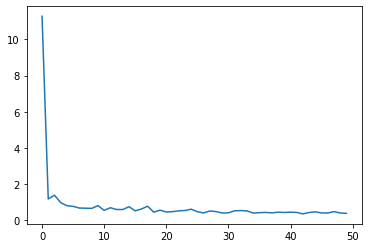

In [76]:
loss_3 = model3.history.history['loss']
plt.plot(range(len(loss_3)),loss_3)

In [77]:
test_predictions_1 = []

first_eval_batch = train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model3.predict(current_batch)[0]
    test_predictions_1.append(current_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

Model: LSTM and Unscaled data
Error = 5.544046986974668


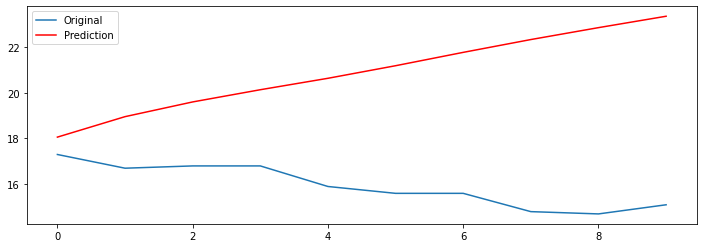

In [78]:
error_and_plot(test,test_predictions_1,'LSTM and Unscaled data')